# PREDICTING BOTTOM HOLE PRESSURE USING MACHINE LEARNING
#####  In the case of well control when using the choke, the bottom hole pressure is estimated to be equal to sum of hydrostatic pressure, annulus pressures losses and the backup pressure hold by the choke. 

### IMPORTING LIBRARIES AND LOADING DATA

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [65]:
xls = pd.ExcelFile('volve_production_data.xlsx')
df = pd.read_excel(xls, 'Daily Production Data') 

In [66]:
df.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


### DATA CLEANING AND PREPOCESSING

In [67]:
# Lets see all columns first
df.columns

Index(['DATEPRD', 'WELL_BORE_CODE', 'NPD_WELL_BORE_CODE', 'NPD_WELL_BORE_NAME',
       'NPD_FIELD_CODE', 'NPD_FIELD_NAME', 'NPD_FACILITY_CODE',
       'NPD_FACILITY_NAME', 'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE',
       'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS',
       'AVG_CHOKE_SIZE_P', 'AVG_CHOKE_UOM', 'AVG_WHP_P', 'AVG_WHT_P',
       'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL',
       'BORE_WI_VOL', 'FLOW_KIND', 'WELL_TYPE'],
      dtype='object')

In [68]:
# Rename column names to a more appropriate one 
column_names = {
    'DATEPRD': 'DATE',
    'WELL_BORE_CODE': 'WELL_ID',
    'NPD_WELL_BORE_CODE': 'WELL_NAME_CODE',
    'NPD_WELL_BORE_NAME': 'WELL_NAME',
    'NPD_FIELD_CODE': 'FIELD_CODE',
    'NPD_FIELD_NAME': 'FIELD_NAME',
    'NPD_FACILITY_CODE': 'FACILITY_CODE',
    'NPD_FACILITY_NAME': 'FACILITY_NAME',
    'ON_STREAM_HRS': 'ON_STREAM_HRS',
    'AVG_DOWNHOLE_PRESSURE': 'BH_PRESSURE',
    'AVG_DOWNHOLE_TEMPERATURE': 'BH_TEMPERATURE',
    'AVG_DP_TUBING': 'DP_TUBING',
    'AVG_ANNULUS_PRESS': 'CASING_PRESSURE',
    'AVG_CHOKE_SIZE_P': 'CHOKE_SIZE_PERCENTAGE',
    'AVG_CHOKE_UOM': 'CHOKE_UNITS',
    'AVG_WHP_P': 'WH_PRESSURE',
    'AVG_WHT_P': 'WH_TEMPERATURE',
    'DP_CHOKE_SIZE': 'DP_CHOKE_SIZE',
    'BORE_OIL_VOL': 'OIL_VOL',
    'BORE_GAS_VOL': 'GAS_VOL',
    'BORE_WAT_VOL': 'WAT_VOL',
    'BORE_WI_VOL': 'WATER_INJ_VOL',
    'FLOW_KIND': 'FLOW_KIND',
    'WELL_TYPE': 'WELL_TYPE'
}

df.rename(columns=column_names, inplace = True)

In [69]:
df.head(2)

,DATE,WELL_ID,WELL_NAME_CODE,WELL_NAME,FIELD_CODE,FIELD_NAME,FACILITY_CODE,FACILITY_NAME,ON_STREAM_HRS,BH_PRESSURE,...,CHOKE_UNITS,WH_PRESSURE,WH_TEMPERATURE,DP_CHOKE_SIZE,OIL_VOL,GAS_VOL,WAT_VOL,WATER_INJ_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.0,...,%,0.0,0.0,0.0,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.0,0.0,0.0,0.0,0.0,0.0,NaN,production,OP


In [70]:
# Drop columns irrelevant to our objective (not relating to bottom hole pressure)
df2 = df.drop(['DATE', 'WELL_ID', 'WELL_NAME_CODE', 'WELL_NAME', 'FIELD_CODE','FIELD_NAME', 'FACILITY_CODE', 'FACILITY_NAME', 'ON_STREAM_HRS','CASING_PRESSURE','DP_CHOKE_SIZE', 
         'CHOKE_UNITS','WATER_INJ_VOL','FLOW_KIND'],axis = 1)

In [71]:
# Selecting only oil producer well for our prediction

df3 =df2[df2['WELL_TYPE']=='OP']
df_prod = df3.drop(['WELL_TYPE'],axis = 1)
df_prod.head(3)

,BH_PRESSURE,BH_TEMPERATURE,DP_TUBING,CHOKE_SIZE_PERCENTAGE,WH_PRESSURE,WH_TEMPERATURE,OIL_VOL,GAS_VOL,WAT_VOL
1,NaN,NaN,NaN,1.003059,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,0.979008,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,0.545759,0.0,0.0,0.0,0.0,0.0


In [72]:
df_prod.describe()

,BH_PRESSURE,BH_TEMPERATURE,DP_TUBING,CHOKE_SIZE_PERCENTAGE,WH_PRESSURE,WH_TEMPERATURE,OIL_VOL,GAS_VOL,WAT_VOL
count,8978.000000,8978.000000,8978.000000,8901.000000,9137.000000,9129.000000,9143.000000,9143.000000,9143.000000
mean,181.820413,77.168114,154.045010,55.186725,45.442082,67.801178,1097.433089,161310.558658,1675.344996
std,109.707241,45.654600,76.743653,36.666334,24.726268,27.669018,1324.191424,188224.781732,1707.141019
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-457.840000
25%,0.000000,0.000000,84.163947,18.992216,31.175563,56.848805,190.890000,29440.970000,20.765000
50%,232.927076,103.186689,175.603884,52.106021,37.989435,80.093188,559.220000,87857.650000,1108.050000
75%,255.405756,106.276408,204.335726,99.923984,57.183170,88.072977,1346.340000,202861.570000,3263.625000
max,397.588550,108.502178,345.906770,100.000000,137.311030,93.509584,5901.840000,851131.520000,8019.740000


In [73]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9143 entries, 1 to 15632
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   BH_PRESSURE            8978 non-null   float64
 1   BH_TEMPERATURE         8978 non-null   float64
 2   DP_TUBING              8978 non-null   float64
 3   CHOKE_SIZE_PERCENTAGE  8901 non-null   float64
 4   WH_PRESSURE            9137 non-null   float64
 5   WH_TEMPERATURE         9129 non-null   float64
 6   OIL_VOL                9143 non-null   float64
 7   GAS_VOL                9143 non-null   float64
 8   WAT_VOL                9143 non-null   float64
dtypes: float64(9)
memory usage: 714.3 KB


In [74]:
#checking for duplicates
df_prod.duplicated()
df_prod.drop_duplicates()

,BH_PRESSURE,BH_TEMPERATURE,DP_TUBING,CHOKE_SIZE_PERCENTAGE,WH_PRESSURE,WH_TEMPERATURE,OIL_VOL,GAS_VOL,WAT_VOL
1,NaN,NaN,NaN,1.003059,0.00000,0.00000,0.0,0.0,0.0
2,NaN,NaN,NaN,0.979008,0.00000,0.00000,0.0,0.0,0.0
3,NaN,NaN,NaN,0.545759,0.00000,0.00000,0.0,0.0,0.0
4,310.37614,96.87589,277.27826,1.215987,33.09788,10.47992,0.0,0.0,0.0
5,303.50078,96.92339,281.44744,3.087015,22.05334,8.70429,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
15628,NaN,NaN,NaN,0.673718,0.08545,0.22889,0.0,0.0,0.0
15629,NaN,NaN,NaN,0.636088,0.07776,0.22879,0.0,0.0,0.0
15630,NaN,NaN,NaN,0.670794,0.08545,0.22914,0.0,0.0,0.0
15631,NaN,NaN,NaN,0.664393,0.08544,0.22896,0.0,0.0,0.0


In [75]:
df_prod.isna().sum()

BH_PRESSURE              165
BH_TEMPERATURE           165
DP_TUBING                165
CHOKE_SIZE_PERCENTAGE    242
WH_PRESSURE                6
WH_TEMPERATURE            14
OIL_VOL                    0
GAS_VOL                    0
WAT_VOL                    0
dtype: int64

In [76]:
df_prod.dropna(inplace=True)
df_prod.reset_index(inplace=True, drop=True)
df_prod.isna().sum()

BH_PRESSURE              0
BH_TEMPERATURE           0
DP_TUBING                0
CHOKE_SIZE_PERCENTAGE    0
WH_PRESSURE              0
WH_TEMPERATURE           0
OIL_VOL                  0
GAS_VOL                  0
WAT_VOL                  0
dtype: int64

<AxesSubplot:xlabel='BH_PRESSURE'>

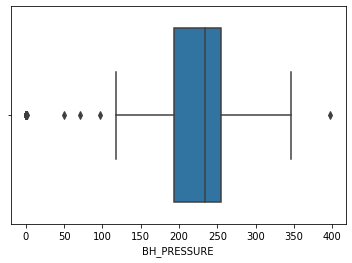

In [77]:
#cHECKING FOR OUTLIERS
import seaborn as sns
sns.boxplot(x= df_prod['BH_PRESSURE'])

In [78]:
#Handling outliers
Q1 = df_prod['BH_PRESSURE'].quantile(0.25)
Q3 = df_prod['BH_PRESSURE'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (df_prod['BH_PRESSURE'] >= Q1 - 1.5 * IQR) & (df_prod['BH_PRESSURE'] <= Q3 + 1.5 *IQR)
df_prod.loc[filter]

,BH_PRESSURE,BH_TEMPERATURE,DP_TUBING,CHOKE_SIZE_PERCENTAGE,WH_PRESSURE,WH_TEMPERATURE,OIL_VOL,GAS_VOL,WAT_VOL
0,310.37614,96.87589,277.27826,1.215987,33.09788,10.47992,0.0,0.0,0.0
1,303.50078,96.92339,281.44744,3.087015,22.05334,8.70429,0.0,0.0,0.0
2,303.53481,96.95885,276.03200,1.962365,27.50281,9.42315,0.0,0.0,0.0
3,303.78228,96.96873,282.78676,0.000000,20.99552,8.13137,0.0,0.0,0.0
4,303.85821,97.02136,289.94067,31.141856,13.91754,8.49833,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
8733,345.90677,90.03433,345.90677,0.999251,0.00000,0.00000,0.0,0.0,0.0
8734,345.90677,90.03433,345.90677,1.049490,0.00000,0.00000,0.0,0.0,0.0
8735,345.90677,90.03433,345.90677,0.974846,0.00000,0.00000,0.0,0.0,0.0
8736,345.90677,90.03433,345.90677,0.968742,0.00000,0.00000,0.0,0.0,0.0


In [79]:
# We still need to do more data cleaning
# My model will be predictive only while the well is open
df_prod = df_prod[(df_prod['OIL_VOL']>0)& (df_prod['BH_PRESSURE']>0)]

## Feature Engineering
#### This is important to make our model more efficient, domain expertise is a main skill needed in this step, We will not user water/ Gas volumes, but instead we will use ratios, because in the oil industry it is well known that GOR and WOR are very good performance indicators in our analysis

In [80]:
df_prod['GOR'] = df_prod['GAS_VOL']/df_prod['OIL_VOL']
df_prod['WC'] = df_prod['WAT_VOL']/(df_prod['WAT_VOL']+df_prod['OIL_VOL'])

In [81]:
# dropping the gas volume and oil volume
df = df_prod.drop(['GAS_VOL','WAT_VOL'], axis=1)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5940 entries, 11 to 8664
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   BH_PRESSURE            5940 non-null   float64
 1   BH_TEMPERATURE         5940 non-null   float64
 2   DP_TUBING              5940 non-null   float64
 3   CHOKE_SIZE_PERCENTAGE  5940 non-null   float64
 4   WH_PRESSURE            5940 non-null   float64
 5   WH_TEMPERATURE         5940 non-null   float64
 6   OIL_VOL                5940 non-null   float64
 7   GOR                    5940 non-null   float64
 8   WC                     5940 non-null   float64
dtypes: float64(9)
memory usage: 464.1 KB


In [83]:
y = df['BH_PRESSURE']
parameters = ['BH_TEMPERATURE', 'DP_TUBING', 'CHOKE_SIZE_PERCENTAGE','WH_PRESSURE', 'WH_TEMPERATURE', 'OIL_VOL', 'GOR', 'WC']
x = df[parameters]

In [84]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

## MODELLING AND PREPROCESSING

In [85]:
# Importing ML models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [86]:
# Importing preprocessing functionalities
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Importing metrics
from sklearn.metrics import mean_squared_error

### USING ML REGRESSION ALGORITHM

In [87]:
def genericml(model):
    pipemodel = Pipeline([
        ('scl', StandardScaler()),
        ('reg', model)
    ])
    pipemodel.fit(x_train, y_train)
    pipemodel.predict(x_test)
    print('The Accuracy score of {} on TEST DATA is {} ' .format(model,pipemodel.score(x_test, y_test)))
    print('The Accuracy score of {} on TRAIN DATA is {} '.format(model,pipemodel.score(x_train, y_train)))
    return pipemodel

In [88]:
with open('pipeline.pkl', 'wb') as f:
    pickle.dump(genericml,f)

#### LINEAR REGRESSION

In [89]:
LRR =  genericml(LinearRegression())

The Accuracy score of LinearRegression() on TEST DATA is 0.9995889321569001 
The Accuracy score of LinearRegression() on TRAIN DATA is 0.9991021407528128 


In [90]:
with open('lr.pkl', 'wb') as f:
    pickle.dump(LRR,f)

#### RANDOM FOREST REGRESSION

In [91]:
RFR = genericml(RandomForestRegressor())

The Accuracy score of RandomForestRegressor() on TEST DATA is 0.9930136803922069 
The Accuracy score of RandomForestRegressor() on TRAIN DATA is 0.9960956226330524 


In [92]:
with open('rf.pkl', 'wb') as f:
    pickle.dump(RFR,f)

#### DECISION TREE REGRESSION

In [93]:
DTR = genericml(DecisionTreeRegressor())

The Accuracy score of DecisionTreeRegressor() on TEST DATA is 0.9871619798310018 
The Accuracy score of DecisionTreeRegressor() on TRAIN DATA is 1.0 


In [94]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(DTR,f)

### USING ARTIFICIAL NEURAL NETWORK

In [95]:
# running an ANN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import optimizers
model = Sequential()
model.add(Dense(32, input_shape = (len(parameters),), activation = 'relu'))
BatchNormalization()
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))
sgd = optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer = sgd, loss = 'mse', metrics=['mae'])
history = model.fit(x_train, y_train.values, validation_split=0.1, batch_size = 700, epochs = 500, verbose = 1)

Epoch 1/500
7/7 [==============================] - 6s 368ms/step - loss: 34207.2773 - mae: 170.2710 - val_loss: 14194.6445 - val_mae: 103.2533
Epoch 2/500
7/7 [==============================] - 1s 120ms/step - loss: 16772.7520 - mae: 101.2845 - val_loss: 14811.7920 - val_mae: 95.8309
Epoch 3/500
7/7 [==============================] - 0s 28ms/step - loss: 8650.5713 - mae: 75.6589 - val_loss: 5354.4438 - val_mae: 65.9964
Epoch 4/500
7/7 [==============================] - 0s 27ms/step - loss: 4812.5322 - mae: 63.4645 - val_loss: 2686.3467 - val_mae: 45.4208
Epoch 5/500
7/7 [==============================] - 0s 29ms/step - loss: 2137.7539 - mae: 37.8908 - val_loss: 1706.9016 - val_mae: 30.6161
Epoch 6/500
7/7 [==============================] - 0s 27ms/step - loss: 1072.1748 - mae: 22.8501 - val_loss: 638.5275 - val_mae: 17.9842
Epoch 7/500
7/7 [==============================] - 0s 25ms/step - loss: 649.9547 - mae: 18.2617 - val_loss: 509.9545 - val_mae: 18.6608
Epoch 8/500
7/7 [===========

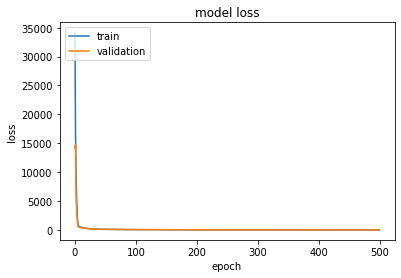

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## MANUAL TESTING

In [97]:
x_test = x.iloc[:10]
y_test = y.iloc[:10]

In [98]:
x.iloc[10]

BH_TEMPERATURE            107.816879
DP_TUBING                 156.690238
CHOKE_SIZE_PERCENTAGE      48.303705
WH_PRESSURE                74.728767
WH_TEMPERATURE             60.747316
OIL_VOL                  1074.040000
GOR                       144.194509
WC                          0.000000
Name: 21, dtype: float64

In [99]:
y.iloc[10]

231.41900520833335

In [100]:
nn = model.predict(x_test).flatten()
ann_pred = nn.tolist()
lr = LRR.predict(x_test).flatten()
lr_pred = lr.tolist()
dt = DTR.predict(x_test).flatten()
dt_pred = dt.tolist()
rf = RFR.predict(x_test).flatten()
rf_pred = rf.tolist()

1/1 [==============================] - 0s 360ms/step


In [101]:
#Mean squred error
mse_ann = mean_squared_error(y_test, ann_pred)
mse_lr = mean_squared_error(y_test, lr_pred)
mse_dt = mean_squared_error(y_test, dt_pred)
mse_rf = mean_squared_error(y_test, rf_pred)

## COMPARING PREDICTED BHP VALUES TO THE ACTUAL BHP

In [102]:
new_df = {'ACTUAL BHP':y_test, 'ANN BHP':ann_pred, 'LR BHP':lr_pred, 'DT BHP':dt_pred,'RF BHP':rf_pred}
df = pd.DataFrame(new_df)
df

,ACTUAL BHP,ANN BHP,LR BHP,DT BHP,RF BHP
11,289.421362,289.509918,289.612995,289.421362,289.331402
12,270.239793,270.175842,270.598338,270.239793,270.687786
13,262.842747,262.783875,263.180376,262.842747,262.176592
14,255.526995,255.658020,255.887371,255.526995,257.527118
15,247.199052,247.366211,247.538774,255.179696,243.524199
16,240.736417,240.908966,241.059978,238.391568,238.791234
17,235.020931,235.310944,235.327963,235.020931,235.984310
18,232.743710,232.882767,233.027020,232.743710,232.577208
19,233.297778,233.318237,233.556659,233.297778,232.932398
20,231.088898,231.142029,231.336018,231.088898,230.961505


In [103]:
from operator import index


err_df = {'MSE_LR':mse_lr,'MSE_DT':mse_dt,'MSE_RF':mse_rf,'MSE_ANN':mse_ann}
df_err = pd.DataFrame(err_df, index=[1,2,3,4,5,6,7,8,9,10])
df_err

,MSE_LR,MSE_DT,MSE_RF,MSE_ANN
1,0.093186,6.9189,2.304688,0.019697
2,0.093186,6.9189,2.304688,0.019697
3,0.093186,6.9189,2.304688,0.019697
4,0.093186,6.9189,2.304688,0.019697
5,0.093186,6.9189,2.304688,0.019697
6,0.093186,6.9189,2.304688,0.019697
7,0.093186,6.9189,2.304688,0.019697
8,0.093186,6.9189,2.304688,0.019697
9,0.093186,6.9189,2.304688,0.019697
10,0.093186,6.9189,2.304688,0.019697


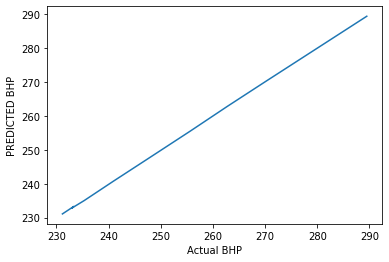

In [104]:
plt.plot(ann_pred, y_test)
plt.xlabel('Actual BHP')
plt.ylabel('PREDICTED BHP')
plt.show()

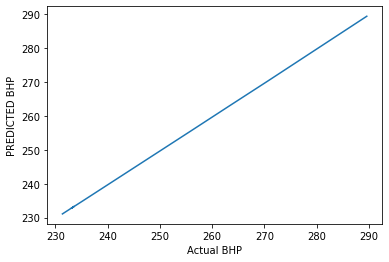

In [105]:
plt.plot(lr_pred, y_test)
plt.xlabel('Actual BHP')
plt.ylabel('PREDICTED BHP')
plt.show()

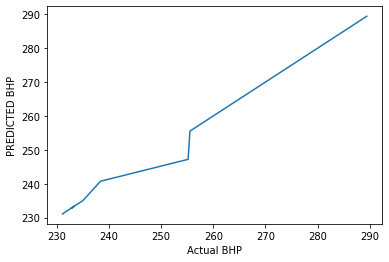

In [106]:
plt.plot(dt_pred, y_test)
plt.xlabel('Actual BHP')
plt.ylabel('PREDICTED BHP')
plt.show()

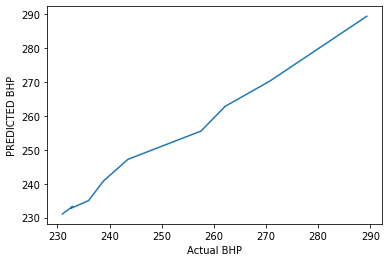

In [107]:
plt.plot(rf_pred, y_test)
plt.xlabel('Actual BHP')
plt.ylabel('PREDICTED BHP')
plt.show()

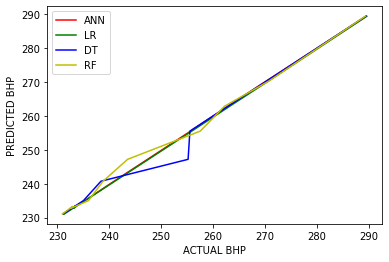

In [108]:
plt.plot(ann_pred, y_test, 'r',label= 'ANN')
plt.plot(lr_pred, y_test,'g',label= 'LR')
plt.plot(dt_pred, y_test,'b',label= 'DT')
plt.plot(rf_pred, y_test,'y',label= 'RF')
plt.xlabel('ACTUAL BHP')
plt.ylabel('PREDICTED BHP')
plt.legend()
plt.show()